# ImageNet Experiments comparing ProtoShotXAI, Grad-CAM, Expected Gradients (SHAP), and LIME


## Initialization, loading model and data

### Imports

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import pickle

input_model_str = 'ResNet50'
if input_model_str == 'Stylized-ImagNet_ResNet50':
    model_filename = '../trained_models/Stylized-ImageNet_ResNet50_image_size_224_epoch_40'
    from tensorflow.keras.applications.resnet50 import preprocess_input
    last_conv_layer_name = 'conv5_block3_3_conv' # Used for Grad-CAM
    layer_num = 38 # Used for Expected Gradients (SHAP)
if input_model_str == 'ResNet50':
    from tensorflow.keras.applications.resnet50 import ResNet50 as keras_model
    from tensorflow.keras.applications.resnet50 import preprocess_input
    last_conv_layer_name = 'conv5_block3_3_conv' # Used for Grad-CAM
    layer_num = 38 # Used for Expected Gradients (SHAP)
elif input_model_str == 'VGG16':
    from tensorflow.keras.applications.vgg16 import VGG16 as keras_model
    from tensorflow.keras.applications.vgg16 import preprocess_input
    last_conv_layer_name = 'block3_conv3' # Used for Grad-CAM
    layer_num = 7 # Used for Expected Gradients (SHAP)
elif input_model_str == 'Xception':
    from tensorflow.keras.applications.xception import Xception as keras_model
    from tensorflow.keras.applications.xception import preprocess_input
    last_conv_layer_name = 'block14_sepconv2' # Used for Grad-CAM
    layer_num = None # Used for Expected Gradients (SHAP)

from tensorflow.keras.layers import Input
from tensorflow.keras.models import load_model

from architectures.protoshotxai import ProtoShotXAI
from utils.ploting_function import xai_plot

### Get Base Model to be Explained (e.g., ResNet50)

In [2]:
if input_model_str == 'Stylized-ImagNet_ResNet50':
    base_model = load_model('../trained_models/Stylized-ImageNet_ResNet50_image_size_224_epoch_40')
else:
    base_model = keras_model(weights="imagenet", include_top=True,input_tensor=Input(shape=(224, 224, 3)))

### Load query sample, support data, and index for class labels

In [3]:
french_bulldog_and_tank = pickle.load(open('../data/french_bulldog_and_tank.pickle','rb'))
query = preprocess_input(french_bulldog_and_tank['french_bulldog_and_tank'])
query = np.expand_dims(np.copy(query),axis=0)
miniImageNet_train_data = np.load('../data/miniImageNet_train_data.npy')

#In ImageNet the french bull dog is class index 245, tank is class index 847
#Using the miniImageNet subset to save space the indicies are 14 and 49, respectively
imagenet_tank_indx = 847
imagenet_bulldog_indx = 245
miniimagenet_tank_indx = 49
miniimagenet_bulldog_indx = 14


## ProtoShotXAI

### Load ProtoShotXAI class and set number of of sample for prototype (e.g.,100)

In [4]:
protoshot = ProtoShotXAI(base_model)
shot = 100

### Use 100 samples for the support prototype of a tank class and run pixel perturbations for feature attribution

In [5]:
#In ImageNet the french bull dog is class index 245, tank is class index 847
#Using the miniImageNet subset to save space the indicies are 14 and 49, respectively
support_data = preprocess_input(miniImageNet_train_data[miniimagenet_tank_indx][:shot])
ref_pixel = query[0,0,0,:] #Average background pixel after preprocessing
print(f'Average background pixel: {ref_pixel}')
protoshot_tank_attributions = protoshot.image_feature_attribution(support_data, query, imagenet_tank_indx, ref_pixel)

Average background pixel: [-0.939 -1.779 -0.68 ]


100%|██████████| 224/224 [02:32<00:00,  1.47it/s]


### Display feature attributions of tank

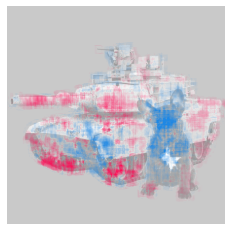

In [6]:
plt = xai_plot(protoshot_tank_attributions,query[0])
plt.savefig(f"./ImageNet_results/ProtoShotXAI_Tank_Features_{input_model_str}.png",dpi=450)

### Use 100 samples for the support prototype of a french bulldog class and run pixel perturbations for feature attribution

In [7]:
#In ImageNet the french bull dog is class index 245, tank is class index 847
#Using the miniImageNet subset to save space the indicies are 14 and 49, respectively
support_data = preprocess_input(miniImageNet_train_data[miniimagenet_bulldog_indx][:shot])
ref_pixel = query[0,0,0,:] #Average background pixel after preprocessing
print(f'Average background pixel: {ref_pixel}')
protoshot_bulldog_attributions = protoshot.image_feature_attribution(support_data, query, imagenet_bulldog_indx, ref_pixel)

Average background pixel: [-0.939 -1.779 -0.68 ]


100%|██████████| 224/224 [02:31<00:00,  1.48it/s]


### Display feature attributions of french bulldog

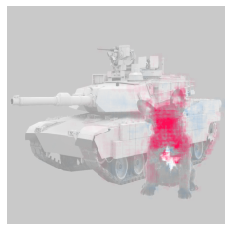

In [8]:
plt = xai_plot(protoshot_bulldog_attributions,query[0])
plt.savefig(f"./ImageNet_results/ProtoShotXAI_French_Bulldog_Features_{input_model_str}.png",dpi=450)


## Grad-CAM 
*Skip this section if using Xception Network

### Create Model Class

In [9]:
from architectures.gradcam import GradCam

# Find last conv laver (Use pre-determined layers instead)
# last_conv_indx = np.where(np.array(list(map(lambda x: 'conv' in x.name, base_model.layers)))==True)[0][-1]
# last_conv_layer_name = base_model.layers[last_conv_indx].name
gradcam = GradCam(base_model,last_conv_layer_name)

### Display Feature Attributions of a Tank

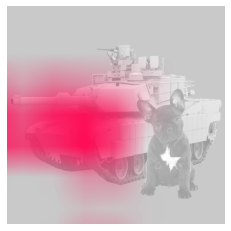

In [10]:

gradcam_tank_attributions = gradcam.make_gradcam_heatmap(query, pred_index= imagenet_tank_indx)
plt = xai_plot(gradcam_tank_attributions,query[0])
plt.savefig(f"./ImageNet_results/Grad-CAM_Tank_Features_{input_model_str}.png",dpi=450)

### Display Feature Attributions of a French Bulldog

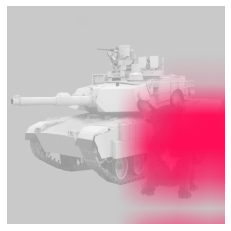

In [11]:
gradcam_bulldog_attributions = gradcam.make_gradcam_heatmap(query, pred_index=imagenet_bulldog_indx)
plt = xai_plot(gradcam_bulldog_attributions,query[0])
plt.savefig(f"./ImageNet_results/Grad-CAM_French_Bulldog_Features_{input_model_str}.png",dpi=450)

## SHAP Expected Gradients (a.k.a GradientExplainer)
*Skip this section if using Xception Network

### GradientExplainer use tensorflow v1 with disable eager execution, need to re-load the model

In [4]:
import tensorflow.compat.v1.keras.backend as K 
import tensorflow as tf
import shap
import json
tf.compat.v1.disable_eager_execution()

if input_model_str == 'Stylized-ImagNet_ResNet50':
    base_model = load_model('../trained_models/Stylized-ImageNet_ResNet50_image_size_224_epoch_40')
else:
    base_model = keras_model(weights="imagenet", include_top=True,input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
Colocations handled automatically by placer.


### Run Expected Gradients

In [14]:
X,y = shap.datasets.imagenet50()
layer_num = 38

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the nth layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([base_model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(base_model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (base_model.layers[layer_num].input, base_model.layers[-1].output),
    map2layer(X, layer_num),
    local_smoothing=0 # std dev of smoothing noise
)
ro = np.zeros((1,2))
ro[0,0] = imagenet_tank_indx
ro[0,1] = imagenet_bulldog_indx
shap_values,indexes = e.shap_values(map2layer(query, layer_num), ranked_outputs=ro.astype(int), output_rank_order ="custom")

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
shap_indx_tank = np.where(index_names[0] == 'tank')[0][0]
shap_indx_bulldog = np.where(index_names[0] == 'French_bulldog')[0][0]

### Display Feature Attributions of a Tank

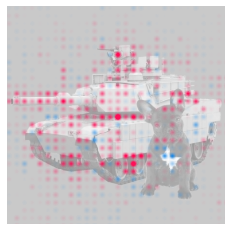

In [15]:
shap_tank_attributions = shap_values[shap_indx_tank][0]
plt = xai_plot(shap_tank_attributions,query[0])
plt.savefig(f"./ImageNet_results/SHAP_Tank_Features_{input_model_str}.png",dpi=450)

### Display Feature Attributions of a French Bulldog

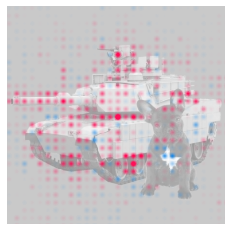

In [16]:
shap_bulldog_attributions = shap_values[shap_indx_bulldog][0]
plt = xai_plot(shap_tank_attributions,query[0])
plt.savefig(f"./ImageNet_results/SHAP_French_Bulldog_Features_{input_model_str}.png",dpi=450)

## Lime
*Sometimes LIME will hang in this jupyter notebook. Usually this can be resolved by restarting the kernel or running it as a script

### Create Model Class

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

### Train LIME Model

In [5]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(query[0], base_model.predict, top_labels=1000, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5min 34s, sys: 14min 34s, total: 20min 8s
Wall time: 28.5 s


### Get lime index for tank and french Bulldog

In [6]:
lime_index_tank = np.where(np.array(explanation.top_labels) == imagenet_tank_indx)[0][0]
lime_index_FB = np.where(np.array(explanation.top_labels) == imagenet_bulldog_indx)[0][0]

### Display Feature Attributions of a Tank

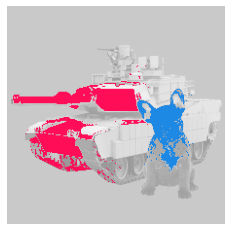

In [7]:
_, lime_tank_attributions = explanation.get_image_and_mask(explanation.top_labels[lime_index_tank], positive_only=False, num_features=10, hide_rest=False)
plt = xai_plot(lime_tank_attributions,query[0])
plt.savefig(f"./ImageNet_results/LIME_Tank_Features_{input_model_str}.png",dpi=450)

### Display Feature Attributions of a French Bulldog

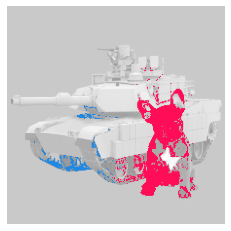

In [8]:
_, lime_bulldog_attributions = explanation.get_image_and_mask(explanation.top_labels[lime_index_FB], positive_only=False, num_features=10, hide_rest=False)
plt = xai_plot(lime_bulldog_attributions,query[0])
plt.savefig(f"./ImageNet_results/LIME_French_Bulldog_Features_{input_model_str}.png",dpi=450)